# Dataloading

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import subprocess
import scipy
from tqdm import tqdm

from utils.wandb_utils import CRLRunCollector
from utils.create_zip import save_loop
from utils.preprocessing import load_zip, bootstrap

np.random.seed(42)

To use this code:
* Label your Wandb runs with tags
* Update the following three cells

If you already have a zip file (either the data we have cached or data you have
constructed yourself), you can set `wandb_collect = False`, which will skip the 
`RunCollector`-related cells. Otherwise, you will need to have a `RunCollector`.

In [3]:
ours_path = 'gym_ours'  # name of your cached RunCollector and zip file
baseline_path = 'gym_baseline_utd2'

return_key = 'episode/return'
logging_freq = 1000  # Wandb logging frequency in steps

# Maximum possible returns (estimated with infinite data and compute) on each
# environment. These are mostly eyeballed such that runs reach 80% (hence
# the 1.25 multiplier) but not 90%. There is considerable variation for different environments.
max_returns = {
    "HalfCheetah-v4": 7300 * 1.25,
    "Walker2d-v4": 4000 * 1.25,
    "Ant-v4": 5300 * 1.25,
    "Humanoid-v4": 5200 * 1.25,
}

thresholds = [300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800]  # out of 1000

wandb_collect = True
assert wandb_collect or (
    os.path.exists(f'cache/zip/{ours_path}.zip')
    and os.path.exists(f'cache/zip/{baseline_path}.zip')
)

In [4]:
if wandb_collect:
    collector_cls = CRLRunCollector
    wandb_project = 'prestonfu/crl'
    wandb_tags_ours = ['sac_optimal_250207']
    wandb_tags_baseline = ['sac_grid_250207_bl_utd2.0']
    
    gym_ours_collector = collector_cls(wandb_project).create(
        load=True,
        tags=wandb_tags_ours,   # Wandb tags to include
        path=f'cache/collector/{ours_path}.npy',
        parallel=True
    )
    
    gym_baseline_collector = collector_cls(wandb_project).create(
        load=True,
        tags=wandb_tags_baseline,   # Wandb tags to include
        path=f'cache/collector/{baseline_path}.npy',
        parallel=True
    )

    # Drop runs that do not go for the full number of steps and extra runs beyond desired number of seeds
    num_seeds = 8
    gym_ours_collector.remove_short(0.95)
    gym_ours_collector.trim(num_seeds, verbose=True)
    gym_baseline_collector.remove_short(0.95)
    gym_baseline_collector.trim(num_seeds, verbose=True)

In [5]:
if wandb_collect:
    for collector, path in [
        (gym_ours_collector, ours_path),
        (gym_baseline_collector, baseline_path)
    ]:
        save_loop(collector, return_key, path, logging_freq=1000)   # Remove logging_freq to save all data
        os.makedirs('cache/zip', exist_ok=True)
        subprocess.run(f"zip -r {path}.zip {path} && mv {path}.zip ../zip", shell=True, check=True, cwd='cache/data')

  adding: gym_ours/ (stored 0%)
  adding: gym_ours/utd_16/ (stored 0%)
  adding: gym_ours/utd_16/HalfCheetah-v4/ (stored 0%)
  adding: gym_ours/utd_16/HalfCheetah-v4/episode.return/ (stored 0%)
  adding: gym_ours/utd_16/HalfCheetah-v4/episode.return/bs_128_lr_0.000864.npy (deflated 33%)
  adding: gym_ours/utd_16/Walker2d-v4/ (stored 0%)
  adding: gym_ours/utd_16/Walker2d-v4/episode.return/ (stored 0%)
  adding: gym_ours/utd_16/Walker2d-v4/episode.return/bs_128_lr_0.000397.npy (deflated 13%)
  adding: gym_ours/utd_16/Ant-v4/ (stored 0%)
  adding: gym_ours/utd_16/Ant-v4/episode.return/ (stored 0%)
  adding: gym_ours/utd_16/Ant-v4/episode.return/bs_128_lr_6.95e-05.npy (deflated 33%)
  adding: gym_ours/utd_16/Humanoid-v4/ (stored 0%)
  adding: gym_ours/utd_16/Humanoid-v4/episode.return/ (stored 0%)
  adding: gym_ours/utd_16/Humanoid-v4/episode.return/bs_128_lr_8.95e-05.npy (deflated 25%)
  adding: gym_ours/utd_1/ (stored 0%)
  adding: gym_ours/utd_1/HalfCheetah-v4/ (stored 0%)
  adding: gy

# Preprocessing

In [6]:
gym_ours_df, (envs, utds, ours_batch_sizes, ours_learning_rates) = load_zip(f'cache/zip/{ours_path}.zip', max_returns, thresholds)
gym_ours_df = bootstrap(gym_ours_df, thresholds)

gym_baseline_df, (_, _, baseline_batch_sizes, baseline_learning_rates) = load_zip(f'cache/zip/{baseline_path}.zip', max_returns, thresholds)
gym_baseline_df = bootstrap(gym_baseline_df, thresholds)

100%|██████████| 28/28 [00:02<00:00, 12.04it/s]


Average standard deviation across all conditions: 4709.73


100%|██████████| 28/28 [00:02<00:00, 12.20it/s]

Average standard deviation across all conditions: 5639.89


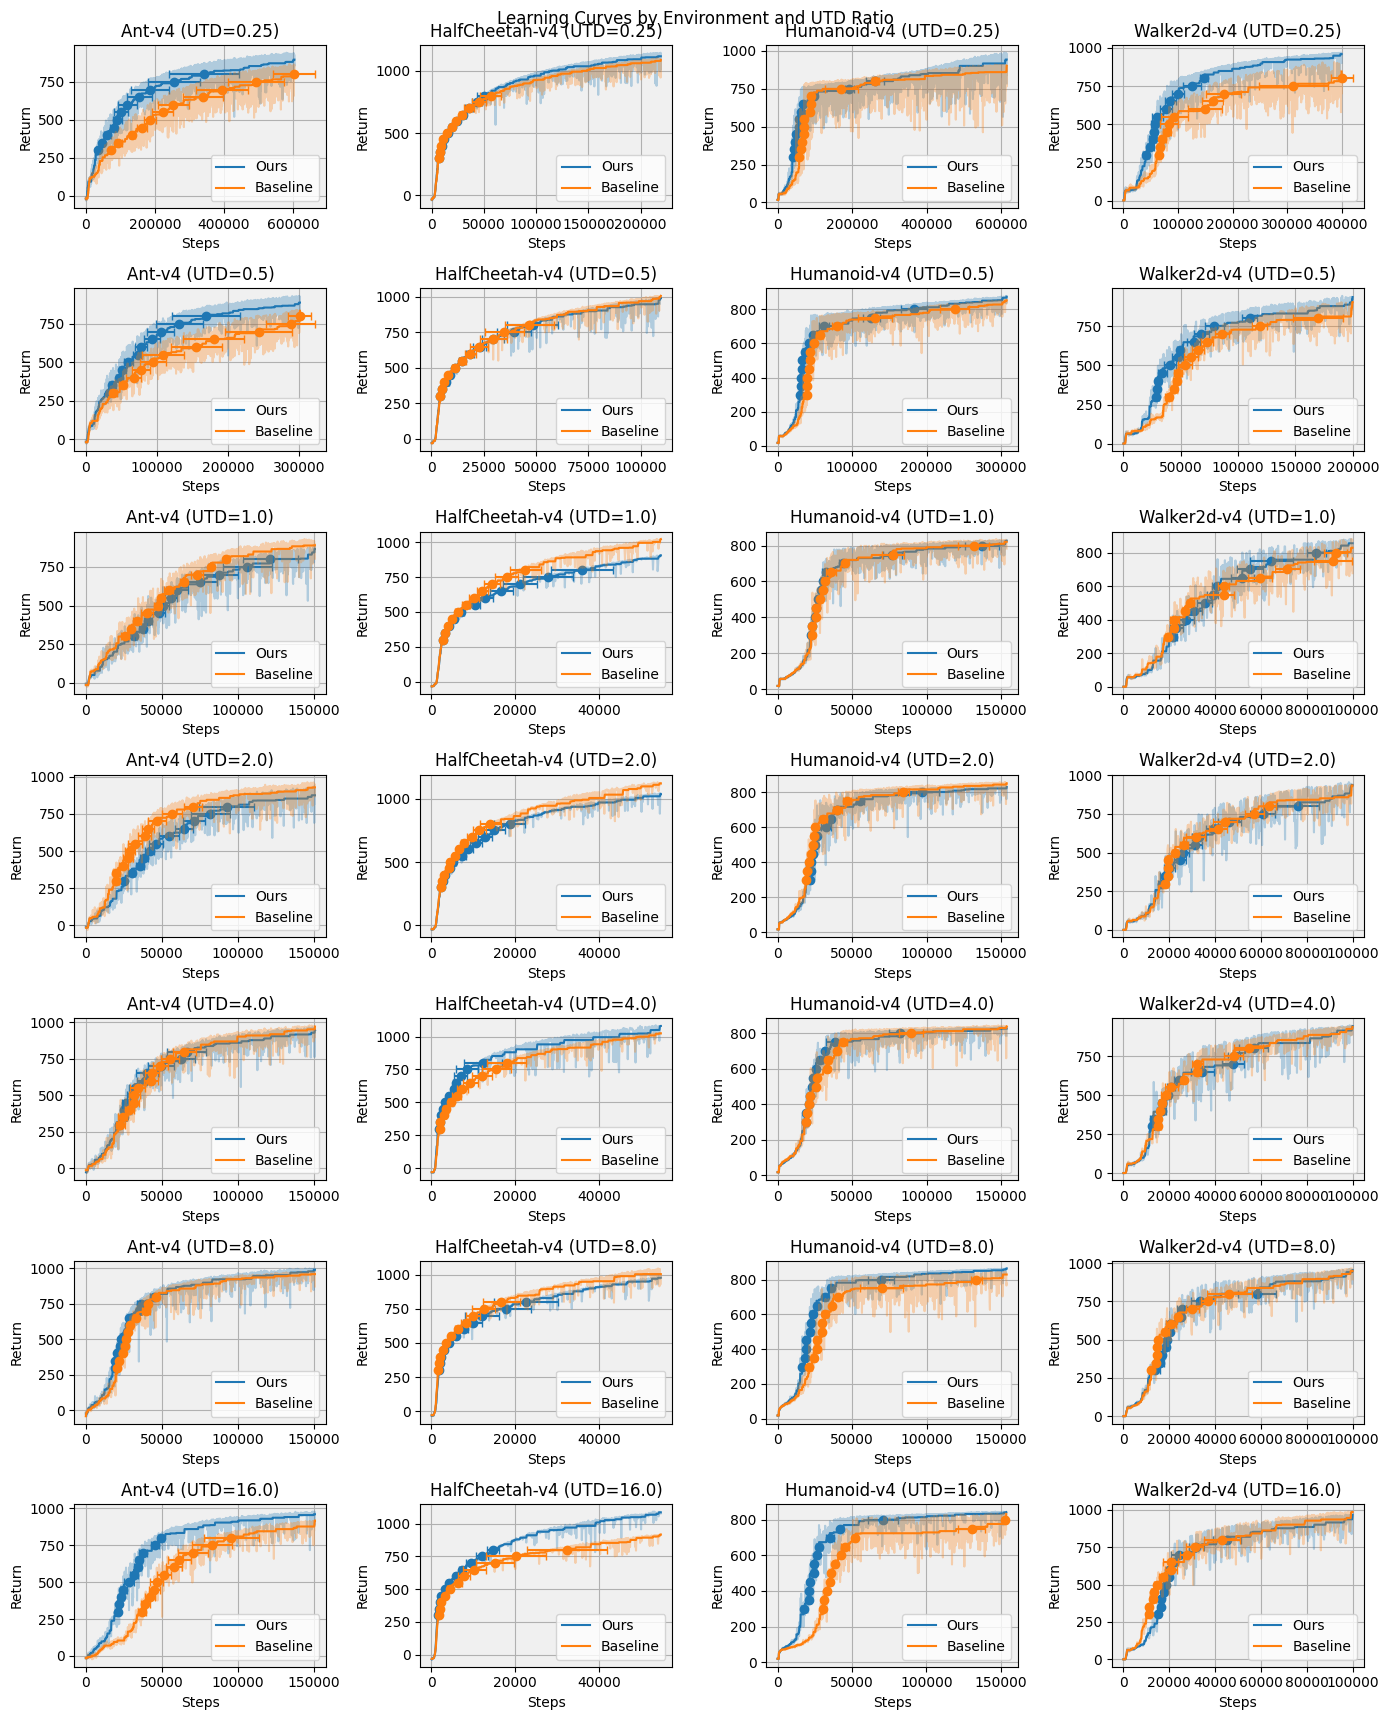

In [7]:
n_envs = len(envs)
n_utds = len(utds)
fig, axs = plt.subplots(n_utds, n_envs, figsize=(3.5*n_envs, 2.5*n_utds))
fig.suptitle('Learning Curves by Environment and UTD Ratio')

def plot_curves(axs, df, label, color):
    # Group data by environment and UTD ratio
    for i, env in enumerate(envs):
        env_data = df[df['env_name'] == env]
        for j, utd in enumerate(sorted(env_data['utd'].unique())):
            utd_data = env_data[env_data['utd'] == utd]
            
            ax = axs[j, i]
            ax.set_title(f'{env} (UTD={utd})')
            
            for _, row in utd_data.iterrows():   
                # ax_label = f"{label}: bs={row['batch_size']}, lr={row['learning_rate']}"
                ax.plot(row['training_step'], row['mean_return'], color=color, alpha=0.3)
                ax.plot(row['training_step'], row['return_isotonic'], color=color, alpha=1, label=label)

                # use the crossings column to plot crossings
                for k, threshold in enumerate(thresholds):
                    crossing_x = row['crossings'][k]
                    crossing_y = threshold
                    ax.plot(crossing_x, crossing_y, 'o', color=color)
                
                # Plot crossing standard deviations as error bars
                for k, threshold in enumerate(thresholds):
                    crossing_x = row['crossings'][k]
                    crossing_y = threshold
                    crossing_std = row['crossings_std'][k]
                    ax.errorbar(crossing_x, crossing_y, xerr=crossing_std, capsize=3, color=color)
            
            ax.set_xlabel('Steps')
            ax.set_ylabel('Return')
            ax.grid(True)
            ax.set_facecolor('#f0f0f0')
            ax.legend()

plot_curves(axs, gym_ours_df, 'Ours', 'tab:blue')
plot_curves(axs, gym_baseline_df, 'Baseline', 'tab:orange')
plt.tight_layout()
plt.show()

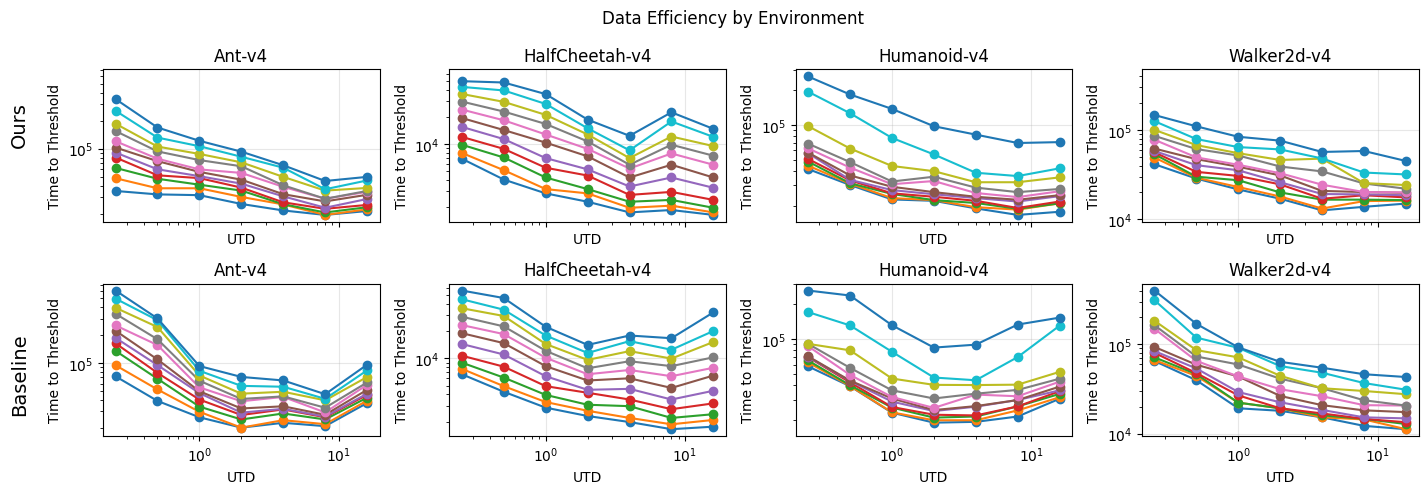

In [8]:
# For a particular threshold, get utds and times

fig, axs = plt.subplots(2, n_envs, figsize=(3.5*n_envs, 2.5*2), sharex='col', sharey='col')
fig.suptitle('Data Efficiency by Environment')

def plot_data_efficiency(axes, df):
    axes = axes.flatten()
    env_data_dict = {}

    for i, env in enumerate(envs):
        env_df = df[df['env_name'] == env]
        
        # Get UTD and crossing times for this environment, sorted by UTD
        utds = sorted(env_df['utd'].values)
        times = [env_df[env_df['utd'] == utd]['crossings'].iloc[0][:] for utd in utds]
        env_data_dict[env] = list(zip(utds, times))
        
        # Plot if we have data
        if len(utds) > 0:
            axes[i].plot(utds, times, 'o-')
            axes[i].set_xlabel('UTD')
            axes[i].set_ylabel('Time to Threshold') 
            axes[i].set_title(env)
            axes[i].set_xscale('log')
            axes[i].set_yscale('log')
            axes[i].grid(True, alpha=0.3)
    
    return env_data_dict


gym_ours_env_data_dict = plot_data_efficiency(axs[0], gym_ours_df)
gym_baseline_env_data_dict = plot_data_efficiency(axs[1], gym_baseline_df)
fig.text(-0.01, 0.75, 'Ours', va='center', ha='center', fontsize=14, rotation=90)
fig.text(-0.01, 0.25, 'Baseline', va='center', ha='center', fontsize=14, rotation=90)
plt.tight_layout()
plt.show()

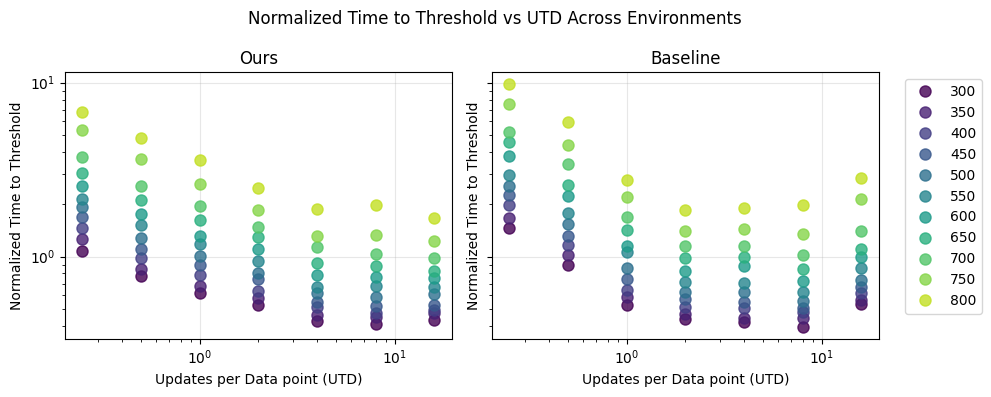

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)


def combine_envs_plot(ax, env_data_dict, label, show_legend: bool):
    # Calculate median times and scaling factors for each environment
    median_times = np.array([np.median(list(zip(*env_data_dict[env]))[1]) for env in envs if len(env_data_dict[env]) > 0])
    median_median = np.median(median_times)
    scaling = 1 / median_times

    # Store the normalized data for each environment
    normalized_times_all = []
    for i, env in enumerate(envs):
        if len(env_data_dict[env]) > 0:
            utds, times = zip(*env_data_dict[env])
            normalized_times = np.array(times) * scaling[i]
            normalized_times_all.append(normalized_times)

    # Calculate and plot the average across all environments
    normalized_times_all = np.array(normalized_times_all)
    mean_normalized_times = np.mean(normalized_times_all, axis=0)
    n_thresholds = mean_normalized_times.shape[-1]

    for i in range(n_thresholds):
        ax.plot(utds, mean_normalized_times[:, i], 'o', color=plt.cm.viridis(i/n_thresholds), 
                label=f'{thresholds[i]}', markersize=8, alpha=0.8)

    ax.set_title(label)
    ax.set_xlabel('Updates per Data point (UTD)')
    ax.set_ylabel('Normalized Time to Threshold')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(True, alpha=0.3)
    if show_legend:
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    return n_thresholds, normalized_times_all, mean_normalized_times, median_median


(
    n_thresholds, 
    gym_ours_normalized_times_all, 
    gym_ours_mean_normalized_times,
    gym_ours_median_median
) = combine_envs_plot(axs[0], gym_ours_env_data_dict, 'Ours', show_legend=False)
(
    _,
    gym_baseline_normalized_times_all,
    gym_baseline_mean_normalized_times,
    gym_baseline_median_median
) = combine_envs_plot(axs[1], gym_baseline_env_data_dict, 'Baseline', show_legend=True)

plt.suptitle('Normalized Time to Threshold vs UTD Across Environments')
plt.tight_layout()
plt.show()

# Asymptotic data efficiency fit

In [10]:
def fit(xs, y, optim_f, init_grid, top_k=500, tol=None, disp=False, maxiter=None):
    _, _, brute_xs, brute_ys = scipy.optimize.brute(optim_f, init_grid, args=(xs, y), full_output=True, finish=None, Ns=1, workers=-1)

    brute_xs = brute_xs.reshape(brute_xs.shape[0], -1)
    brute_ys = brute_ys.reshape(-1)

    top_idxs = np.argsort(brute_ys)[:top_k]
    top_xs = brute_xs[:, top_idxs]
    preds = []
    for i in tqdm(range(top_xs.shape[1])):
        options = {'disp': disp}
        if maxiter: options['maxiter'] = maxiter
        pred = scipy.optimize.minimize(optim_f, top_xs[:, i], args=(xs, y), method='L-BFGS-B', tol=tol, options=options).x
        loss = optim_f(pred, xs, y)
        # print(pred, loss)
        preds.append((pred, loss))
    return sorted(preds, key=lambda x: x[1])[0][0]


def power_law_with_const_min(args, *params):
    x,y = params
    a,b,c = args
    with np.errstate(invalid='ignore', divide='ignore'):
        return ((np.log(power_law_with_const(x,a,b,c) / y)) ** 2).mean()


def power_law_with_const(x, a, b, c): 
    return c * (1 + (x/b)**(-a))

In [11]:
# Pareto fit
def make_pareto_fits(n_thresholds, mean_normalized_times):
    # Plot mean data points
    fits = []
    for i in range(n_thresholds):
        # Fit power law with constant for each threshold
        params = fit(utds[:], mean_normalized_times[:, i], power_law_with_const_min,[slice(-2, 2, 0.8), slice(0, 1, 0.2), slice(-2, 2, 0.8)], maxiter=100)
        fits.append(params)

    return fits

gym_ours_fits = make_pareto_fits(n_thresholds, gym_ours_mean_normalized_times)
gym_baseline_fits = make_pareto_fits(n_thresholds, gym_baseline_mean_normalized_times)

  0%|          | 0/125 [00:00<?, ?it/s]/tmp/ipykernel_2106553/4198437483.py:28: RuntimeWarning: overflow encountered in power
  return c * (1 + (x/b)**(-a))
 14%|█▎        | 17/125 [00:00<00:00, 162.09it/s]/tmp/ipykernel_2106553/4198437483.py:28: RuntimeWarning: overflow encountered in multiply
  return c * (1 + (x/b)**(-a))
 27%|██▋       | 34/125 [00:00<00:00, 163.75it/s]/tmp/ipykernel_2106553/4198437483.py:24: RuntimeWarning: overflow encountered in divide
  return ((np.log(power_law_with_const(x,a,b,c) / y)) ** 2).mean()
/home/preston/miniconda3/envs/value-scaling/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:596: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0
100%|██████████| 125/125 [00:00<00:00, 226.56it/s]


TODO: figure out compute

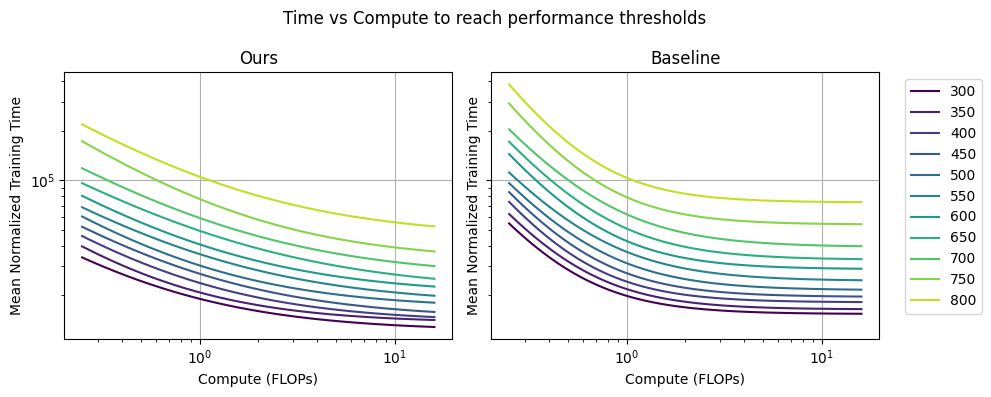

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

def plot_pareto_fits(ax, fits, median_median, label: str, show_legend: bool):
    for i in (range(n_thresholds)):
        x_smooth = np.logspace(np.log10(min(utds)), np.log10(max(utds)), 100)
        a, b, c = fits[i]
        data = power_law_with_const(x_smooth, a, b, c) * median_median
        utd = x_smooth

        grad_steps = utd * data
        batch_sizes = 300 * (utd)**(-0.3)
        compute = grad_steps * batch_sizes * 10 * 1.5e5
        
        # Plot the fit
        ax.plot(utd, data, '-',
                color=plt.cm.viridis(i/n_thresholds), 
                label=thresholds[i])

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(True)
    ax.set_xlabel('Compute (FLOPs)')
    ax.set_ylabel('Mean Normalized Training Time')
    ax.set_title(label)
    if show_legend:
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
    os.makedirs('data/fits', exist_ok=True)
    np.save(f'data/fits/{label.lower()}_fits.npy', fits)

    return x_smooth


gym_x_smooth = plot_pareto_fits(axs[0], gym_ours_fits, gym_ours_median_median, 'Ours', show_legend=False)
_ = plot_pareto_fits(axs[1], gym_baseline_fits, gym_baseline_median_median, 'Baseline', show_legend=True)
plt.suptitle('Time vs Compute to reach performance thresholds')
plt.tight_layout()
plt.show()

# Final plots

In [13]:
from rliable import plot_utils
COLORS = ['#BBCC33', '#77AADD', '#44BB99',
           '#EEDD88', '#EE8866', '#FFAABB',
          '#99DDFF', '#AAAA00', '#DDDDDD']
palette = sns.set_palette(COLORS)
plt.rcParams['text.usetex'] = False #Let TeX do the typsetting
plt.rcParams['text.latex.preamble'] = r'\usepackage{sansmath} \sansmath' #Force sans-serif math mode (for axes labels)
plt.rcParams['font.family'] = 'sans-serif' # ... for regular text
plt.rcParams['font.sans-serif'] = ['Helveta Nue'] # Choose a nice font here
sns.set_style("whitegrid")

ModuleNotFoundError: No module named 'rliable'

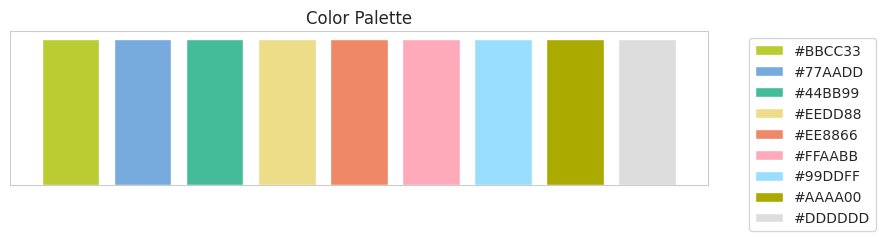

In [ ]:
plt.figure(figsize=(9,2))
for i, color in enumerate(COLORS):
    plt.bar(i, 1, color=color, label=color)
plt.xticks([])
plt.yticks([])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Color Palette')
plt.show()

Fits using threshold 800
Ours: y = 1.44 * (1 + (x/1.43)**(-0.77)
Constant fit: y = 2.06 * (1 + (x/0.59)**(-1.67)


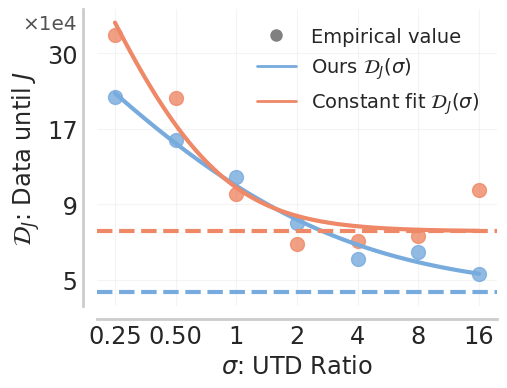

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(10,8))
fig.set_size_inches(496.0/192*2, 369.6/192*2)

pareto_fit_idx = -1
print(f'Fits using threshold {thresholds[pareto_fit_idx]}')

def plot_pareto_fit_formatted(idx, x_smooth, median_median, fits, normalized_times_all, label, color):
    a, b, c = fits[idx]
    print(f'{label}: y = {c:.2f} * (1 + (x/{b:.2f})**(-{a:.2f})')
    utd_line = x_smooth
    data_line = power_law_with_const(x_smooth, a, b, c) * median_median
    plt.scatter(
        utds, 
        np.mean(normalized_times_all[..., idx], axis=0) * median_median, 
        marker='o', 
        color=color, 
        label=f'{label} empirical value', 
        alpha=0.8, 
        s=100
    )
    plt.plot(utd_line, data_line, color, linewidth=3, label=label + ' $\mathcal{D}_J(\sigma)$')

    # Asymptote
    plt.axhline(y=c * median_median, color=color, linewidth=3, linestyle='--', label=label + ' $\mathcal{D}_J^{\mathrm{min}}$')

    plt.xscale('log')
    plt.yscale('log')
    x = np.logspace(np.log10(min(utds)), np.log10(max(utds)), num=len(utds))
    x_ticks_labels = [round(x) if x >= 1 else f"{x:.2f}" for x in x]
    # x_ticks_labels = [f"{x:.2f}" for x in x]
    axs.set_xticks(x, x_ticks_labels)
    yticks = np.logspace(np.log10(50000), np.log10(300000), num=4, dtype=int)
    ylabels = ["%2.f" % (y/10000) for y in yticks]
    axs.yaxis.set_major_locator(plt.FixedLocator(yticks))
    axs.yaxis.set_minor_locator(plt.NullLocator()) 
    axs.set_yticks(yticks, ylabels, size=14.5)

    plot_utils._annotate_and_decorate_axis(axs, xlabel='$\sigma$: UTD Ratio',
                                        ylabel='$\mathcal{D}_J$: Data until $J$',
                                        labelsize='xx-large', ticklabelsize='xx-large',
                                        grid_alpha=0.2, legend=False)
    
plot_pareto_fit_formatted(
    pareto_fit_idx,
    gym_x_smooth, 
    gym_ours_median_median, 
    gym_ours_fits, 
    gym_ours_normalized_times_all, 
    label='Ours', 
    color=COLORS[1])

plot_pareto_fit_formatted(
    pareto_fit_idx,
    gym_x_smooth, 
    gym_baseline_median_median, 
    gym_baseline_fits, 
    gym_baseline_normalized_times_all, 
    label='Constant fit',
    color=COLORS[4]
)


from matplotlib.lines import Line2D

legend_handles = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=10, label="Empirical value"),
    Line2D([0], [0], linestyle='-', linewidth=2, markersize=10, color=COLORS[1], label=r"Ours $\mathcal{D}_J(\sigma)$"),
    Line2D([0], [0], linestyle='-', linewidth=2, markersize=10, color=COLORS[4], label=r"Constant fit $\mathcal{D}_J(\sigma)$"),
]
plt.legend(handles=legend_handles, prop={'size': 14}, frameon=False)
plt.text(-0.05, 0.92, '×1e4', transform=axs.transAxes,
        horizontalalignment='right', verticalalignment='bottom', 
        fontsize='x-large', alpha=0.8)
plt.show()

Threshold = 800
y = 1.44 * (1 + (x/1.43)**(-0.77)
Threshold = 800
y = 2.06 * (1 + (x/0.59)**(-1.67)


/tmp/ipykernel_2100795/3415610131.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs.legend(prop={'size': 14}, ncol=1, frameon=False)
/tmp/ipykernel_2100795/3415610131.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs.legend(prop={'size': 14}, ncol=1, frameon=False)


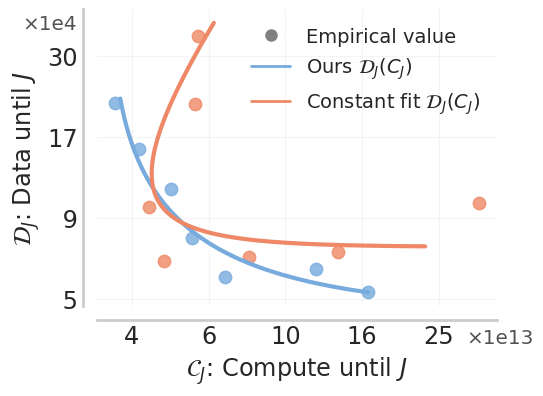

In [ ]:
# Pareto fit 

fig, axs = plt.subplots(1, 1)
fig.set_size_inches(496.0/192*2, 369.6/192*2)

def make_final_pareto_fit(idx, utds, fits, x_smooth, median_median, normalized_times_all, label, color):
    print(f'Threshold = {thresholds[idx]}')
    a, b, c = fits[idx]
    print(f'y = {c:.2f} * (1 + (x/{b:.2f})**(-{a:.2f})')
    data = power_law_with_const(x_smooth, a, b, c) * median_median
    utd_line = x_smooth
    data_line = power_law_with_const(x_smooth, a, b, c) * median_median

    utds = np.array(utds)
    data = np.mean(normalized_times_all[..., idx], axis=0) * median_median

    grad_steps = utds * data
    batch_sizes = 300 * (utds)**(-0.3)
    compute = grad_steps * batch_sizes * 10 * 1.5e5

    grad_steps_line = utd_line * data_line
    batch_sizes_line = 300 * (utd_line)**(-0.3)
    compute_line = grad_steps_line * batch_sizes_line * 10 * 1.5e5


    plt.scatter(compute[:], data[:], marker='o', color=color,alpha=0.8, s=80)
    # plt.scatter(compute[-1], data[-1], marker='x', color=COLORS[1], label='Extrapolation', alpha=0.8, s=80, linewidth=3)
    # plt.scatter(utds, np.mean(normalized_times_all[..., -1], axis=0), marker='o', color=COLORS[1], label='Empirical value', alpha=0.8)
    plt.plot(compute_line, data_line, color, linewidth=3)


    plt.xscale('log')
    plt.yscale('log')
    axs.legend(prop={'size': 14}, ncol=1, frameon=False)

    x = np.logspace(np.log10(4e13), np.log10(25e13), num=5)
    x_ticks_labels = [f"{x / 1e13:.0f}" for x in x]
    axs.xaxis.set_major_locator(plt.FixedLocator(x))
    axs.xaxis.set_minor_locator(plt.NullLocator()) 
    axs.set_xticks(x,x_ticks_labels)

    yticks = np.logspace(np.log10(50000), np.log10(300000), num=4, dtype=int)
    ylabels = ["%2.f" % (y/10000) for y in yticks]
    axs.yaxis.set_major_locator(plt.FixedLocator(yticks))
    axs.yaxis.set_minor_locator(plt.NullLocator()) 
    axs.set_yticks(yticks, ylabels, size=14.5)

    plot_utils._annotate_and_decorate_axis(axs, xlabel='$\mathcal{C}_J$: Compute until $J$',
                                        ylabel='$\mathcal{D}_J$: Data until $J$',
                                        labelsize='xx-large', ticklabelsize='xx-large',
                                        grid_alpha=0.2, legend=False)


make_final_pareto_fit(pareto_fit_idx, utds, gym_ours_fits, gym_x_smooth,
                      gym_ours_median_median, gym_ours_normalized_times_all,
                      'Ours', COLORS[1])

make_final_pareto_fit(pareto_fit_idx, utds, gym_baseline_fits, gym_x_smooth,
                      gym_baseline_median_median, gym_baseline_normalized_times_all,
                      'Baseline', COLORS[4])

legend_handles = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=10, label="Empirical value"),
    Line2D([0], [0], linestyle='-', linewidth=2, markersize=10, color=COLORS[1], label=r"Ours $\mathcal{D}_J(C_J)$"),
    Line2D([0], [0], linestyle='-', linewidth=2, markersize=10, color=COLORS[4], label=r"Constant fit $\mathcal{D}_J(C_J)$"),
]
plt.legend(handles=legend_handles, prop={'size': 14}, frameon=False)
plt.text(1.09, -0.14, '×1e13', transform=axs.transAxes, 
        horizontalalignment='right', verticalalignment='bottom',
        fontsize='x-large', alpha=0.8)
plt.text(-0.05, 0.92, '×1e4', transform=axs.transAxes,
        horizontalalignment='right', verticalalignment='bottom', 
        fontsize='x-large', alpha=0.8)
plt.show()

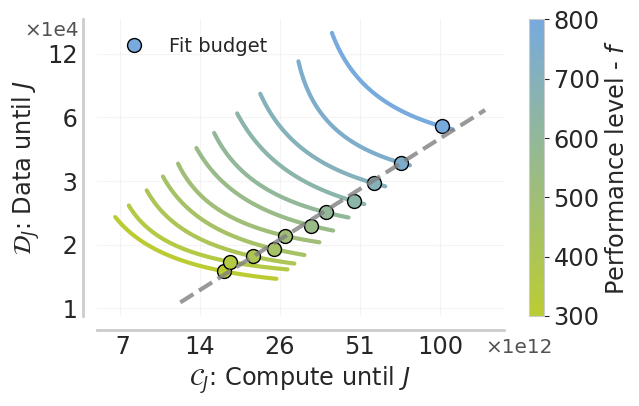

In [17]:
def plot_ours_budget(fits, median_median, normalized_times_all):
    # Plot pareto fits

    fig, axs = plt.subplots(1, 1)
    fig.set_size_inches(496.0/192*2 * 1.27, 369.6/192*2)

    from matplotlib.colors import LinearSegmentedColormap
    cmap = LinearSegmentedColormap.from_list("custom_gradient", [COLORS[0], COLORS[1]])
    n_colors = n_thresholds
    colors = [cmap(i / (n_colors - 1)) for i in range(n_colors)]


    min_points_compute = []
    min_points_data = []
    min_points_utd = []

    for i in (range(n_thresholds)):
        # Generate smooth curves and plot fits for each threshold
        x_smooth = np.logspace(np.log10(0.5), np.log10(8), 100)
        a, b, c = fits[i]
        data = power_law_with_const(x_smooth, a, b, c) * median_median
        utd = x_smooth

        # Convert UTD ratio to compute using the formula from dmc_data5_fits.ipynb
        grad_steps = utd * data
        batch_sizes = 300 * (utd)**(-0.3)
        compute = grad_steps * batch_sizes * 10 * 1.5e5
        
        # Plot the fit
        plt.plot(compute, data, '-', color=colors[i], linewidth=3)
        
        # Find and mark minimum point
        beta = 5e9
        min_idx = np.argmin(compute + beta * data)
        plt.plot(compute[min_idx], data[min_idx], 'o',
                    color=colors[i],
                    markersize=10,
                    label='Fit budget' if i == len(thresholds) - 1 else None,
                    markeredgecolor='black',
                    )
        
        # Store min points for fitting line
        min_points_compute.append(compute[min_idx])
        min_points_data.append(data[min_idx])
        min_points_utd.append(utd[min_idx])       
        
    # UTD extrapolation line
    min_points_utd = np.array(min_points_utd)
    min_points_data = np.array(min_points_data)
    min_points_compute = np.array(min_points_compute)
    # Fit line in log space
    coeffs = np.polyfit(np.log10(min_points_compute), np.log10(min_points_data), 1)
    # Generate points for the ours line
    x_range = np.log10(min(min_points_compute)), np.log10(max(min_points_compute))
    x_line = np.logspace(x_range[0] - 0.2 * (x_range[1] - x_range[0]), x_range[1] + 0.2 * (x_range[1] - x_range[0]), 100)
    y_line = 10**(coeffs[0] * np.log10(x_line) + coeffs[1])
    plt.plot(x_line, y_line, '--', color='gray', linewidth=3, alpha=0.8)
        
    plt.xscale('log')
    plt.yscale('log')
    axs.legend(prop={'size': 14}, ncol=1, frameon=False)

    x = np.logspace(np.log10(7e12), np.log10(100e12), num=5, dtype=int)
    xlabels = ["%2.f" % (y/1e12) for y in x]
    axs.xaxis.set_major_locator(plt.FixedLocator(x))
    axs.xaxis.set_minor_locator(plt.NullLocator()) 
    axs.set_xticks(x, xlabels, size=14.5)

    yticks = np.logspace(np.log10(10000), np.log10(120000), num=5, dtype=int)
    ylabels = ["%2.f" % (y/10000) for y in yticks]
    axs.yaxis.set_major_locator(plt.FixedLocator(yticks))
    axs.yaxis.set_minor_locator(plt.NullLocator()) 
    axs.set_yticks(yticks, ylabels, size=14.5)

    plot_utils._annotate_and_decorate_axis(axs, xlabel='$\mathcal{C}_J$: Compute until $J$',
                                        ylabel='$\mathcal{D}_J$: Data until $J$',
                                        labelsize='xx-large', ticklabelsize='xx-large',
                                        grid_alpha=0.2, legend=False)

    plt.text(1.12, -0.14, '×1e12', transform=axs.transAxes, 
            horizontalalignment='right', verticalalignment='bottom',
            fontsize='x-large', alpha=0.8)
    plt.text(-0.045, 0.93, '×1e4', transform=axs.transAxes,
            horizontalalignment='right', verticalalignment='bottom', 
            fontsize='x-large', alpha=0.8)

    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(thresholds), vmax=max(thresholds)))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=plt.gca())
    cbar.set_label('Performance level - $f$', size='xx-large')
    cbar.ax.tick_params(labelsize='xx-large')

    plt.show()
    
    return min_points_compute, min_points_data, min_points_utd, beta


(
    gym_min_points_compute, 
    gym_min_points_data, 
    gym_min_points_utd, 
    gym_beta    
) = plot_ours_budget(gym_ours_fits, gym_ours_median_median, gym_ours_normalized_times_all)

11
11


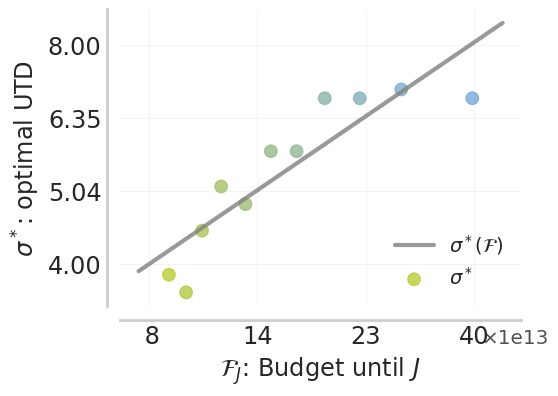

In [ ]:
def plot_budget_extrapolation(fits, min_points_compute, min_points_data, min_points_utd, beta):
    fig, axs = plt.subplots(1, 1)
    fig.set_size_inches(496.0/192*2 , 369.6/192*2)

    from matplotlib.colors import LinearSegmentedColormap
    cmap = LinearSegmentedColormap.from_list("custom_gradient", [COLORS[0], COLORS[1]])
    n_colors = n_thresholds
    colors = [cmap(i / (n_colors - 1)) for i in range(n_colors)]

    # Fit line in log space

    min_points_budget = min_points_compute + beta * min_points_data
    fit_points = [0,1,2,3,4,5,6,7,8,9,10]
    print(len(min_points_budget))
    print(len(min_points_budget[fit_points]))
    coeffs = np.polyfit(np.log10(min_points_budget[fit_points]), np.log10(min_points_utd[fit_points]), 1)
    # Generate points for the ours line
    budget_range = np.log10(min(min_points_budget)), np.log10(max(min_points_budget))
    budget_line = np.logspace(budget_range[0] - 0.1 * (budget_range[1] - budget_range[0]), budget_range[1] + 0.1 * (budget_range[1] - budget_range[0]), 100)
    utd_line = 10**(coeffs[0] * np.log10(budget_line) + coeffs[1])
    plt.plot(budget_line, utd_line, color='gray', linewidth=3, alpha=0.8, label='$\sigma^*(\mathcal{F})$')
    plt.scatter(min_points_budget[:], min_points_utd[:], marker='o', color=colors[:], label='$\sigma^*$', alpha=0.8, s=80)
    # plt.scatter(min_points_budget[-1:], min_points_utd[-1:], marker='x', color=colors[-1:], label='Extrapolation', alpha=0.8, s=80, linewidth=3)

    plt.xscale('log')
    plt.yscale('log')
    axs.legend(prop={'size': 14}, ncol=1, frameon=False, loc='lower right')


    x = np.logspace(np.log10(8e13), np.log10(40e13), num=4, dtype=int)
    xlabels = ["%2.f" % (y/1e13) for y in x]
    axs.xaxis.set_major_locator(plt.FixedLocator(x))
    axs.xaxis.set_minor_locator(plt.NullLocator()) 
    axs.set_xticks(x, xlabels, size=14.5)

    yticks = np.logspace(np.log10(4), np.log10(8), num=4)
    ylabels = ["%2.2f" % (y) for y in yticks]
    axs.yaxis.set_major_locator(plt.FixedLocator(yticks))
    axs.yaxis.set_minor_locator(plt.NullLocator()) 
    axs.set_yticks(yticks, ylabels, size=14.5)

    plot_utils._annotate_and_decorate_axis(axs, xlabel='$\mathcal{F}_J$: Budget until $J$',
                                        ylabel='$\sigma^*$: optimal UTD',
                                        labelsize='xx-large', ticklabelsize='xx-large',
                                        grid_alpha=0.2, legend=False)

    plt.text(1.07, -0.14, '×1e13', transform=axs.transAxes, 
            horizontalalignment='right', verticalalignment='bottom',
            fontsize='x-large', alpha=0.8)
    plt.show()
    

plot_budget_extrapolation(gym_ours_fits, gym_min_points_compute, gym_min_points_data, gym_min_points_utd, gym_beta)